# Decision analysis with Julia `DecisionProgramming.jl` using Petitti, 2000, 2e. - Chapter 2 
Tomás Aragón, Updated 2026-01-21

Chapter 2 from Petitti, Diana B. Meta-Analysis, Decision Analysis, and Cost-Effectiveness Analysis: Methods for Quantitative Synthesis in Medicine. 2nd ed. Monographs in Epidemiology and Biostatistics, v. 31. Oxford University Press, 2000. https://doi.org/10.1093/acprof:oso/9780195133646.001.0001.

This Julia Jupyter notebook was created in VS Code and contains examples from Petitti 2000, Chapter 2. You can run this notebook in VS Code, Positron, or JupyterLab with a Julia kernel. To learn about the Julia language visit https://julialang.org/ .

We will use `DecisionProgramming.jl` Julia package: https://gamma-opt.github.io/DecisionProgramming.jl/dev/ . `DecisionProgramming.jl` is a Julia package for modeling and solving decision analysis problems using influence diagrams.

Preparation: 
- Read [Section 2.2 of Chapter 2](https://github.com/tomasaragon/di4h/blob/main/files/Decision-Analysis_Petitti_2000_isbn_9780195133646_ch02.pdf) in Petitti 2000 book. 
- Review [R Jupyter Notebook of decision analysis of Chapter 2 using `rdecision`](https://github.com/tomasaragon/di4h/blob/main/notebooks/Petitti_2000_2e_ch02/Petitti_2000_2e_ch02_R.ipynb). - We will replicate this R analysis in Julia. 
- Review `DecisionProgramming.jl` GitHub page for introduction to syntax: https://github.com/gamma-opt/DecisionProgramming.jl . 
  - Documentation is here: https://gamma-opt.github.io/DecisionProgramming.jl/dev/ 


Optional readings for background:
- Owens, Douglas K. “Analytic Tools for Public Health Decision Making.” Medical Decision Making: An International Journal of the Society for Medical Decision Making 22, no. 5 Suppl (2002): S3-10. https://doi.org/10.1177/027298902237969.
- Owens, D. K., R. D. Shachter, and R. F. Nease. “Representation and Analysis of Medical Decision Problems with Influence Diagrams.” Medical Decision Making: An International Journal of the Society for Medical Decision Making 17, no. 3 (1997): 241–62. https://doi.org/10.1177/0272989X9701700301.
- Nease, R. F., and D. K. Owens. “Use of Influence Diagrams to Structure Medical Decisions.” Medical Decision Making: An International Journal of the Society for Medical Decision Making 17, no. 3 (1997): 263–75. https://doi.org/10.1177/0272989X9701700302.
- Neapolitan, Richard, Xia Jiang, Daniela P. Ladner, and Bruce Kaplan. “A Primer on Bayesian Decision Analysis With an Application to a Kidney Transplant Decision.” Transplantation 100, no. 3 (2016): 489–96. https://doi.org/10.1097/TP.0000000000001145.

Here is the decision tree from Petitti, 2000, 2e, Chapter 2, Figure 2-6 (FIGURE 1). 

<figure>
<img src="Petitti_2000_2e_ch02_fig2-6.png" width="800" alt="Petitti 2000 Figure 2-6"/>
<figcaption>FIGURE 1</figcaption>
</figure>

Now, here is the decision tree as an influence diagram (FIGURE 2). Notice there is no arrow from the measles node to the value node. The value node only contains input information on revaccination status and mortality based on the scenario. If measles morbidity had been included in the scenario then we would have added an arrow from the measles node to value node. I find influence diagrams more concise and interpretable. Because influence diagrams are directed acyclic graphs (DAGs), they promote causal reasoning. 

<figure>
<img src="img_measles_decision_network_drawio.png" width="600" alt="Petitti 2000 Figure 2-1"/>
<figcaption>FIGURE 2</figcaption> 
</figure>

## Set nodes, incoming edges, and states

In [1]:
using JuMP, HiGHS
using DecisionProgramming

### Set nodes with name, incoming edges, and states 

For example, consider,

`add_node!(diagram, ChanceNode("M", ["R", "E"], ["M1", "M0"]))` 

- `"M"` is the name of the node (measles)
- `["R", "E"]` are the incoming edges from node R (Revaccinate) and node E (Exposure). This is called the "information set" of node M.
- `["M1", "M0"]` are the states of node M: "M1" = Measles $(M=1)$, "M0" = No Measles $(M=0)$

I chose to use "M1" and "M0" because it is much easier to read in the code.

In [2]:
diagram = InfluenceDiagram()
add_node!(diagram, DecisionNode("R", [], ["R1", "R0"])) 
add_node!(diagram, ChanceNode("E", [], ["E1", "E0"])) 
add_node!(diagram, ChanceNode("M", ["R", "E"], ["M1", "M0"])) 
add_node!(diagram, ChanceNode("D", ["M"], ["D1", "D0"])) 
add_node!(diagram, ValueNode("V", ["R", "D"]));

### Generate arcs 

In [3]:
generate_arcs!(diagram) 

OrderedCollections.OrderedDict{String, Utilities}()

### options for viewing diagram attributes  
`diagram.OPTION` where `OPTION` = `Nodes`, `Names`, `I_j`, `States`, `S`, `C`, `D`, or `V`.

In [4]:
diagram.I_j

OrderedCollections.OrderedDict{String, Vector{String}} with 5 entries:
  "R" => []
  "E" => []
  "M" => ["R", "E"]
  "D" => ["M"]
  "V" => ["R", "D"]

## Assign probabilities to variables
For clarity, here is how the notation works:

- `p_E1` $=P(E = 1) = 0.20$
- `p_M1_E1_R1` $= P(M = 1 \mid E = 1, R = 1) = 0.05$
- `p_M1_E1_R0` $= P(M = 1 \mid E = 1, R = 0) = 0.33$
- `p_D1_M1` $= P(D = 1 \mid M = 1) = 0.0023$

In [5]:
# probabilities
# Pr(exposure)
p_E1 = 0.20
p_E0 = 1 - p_E1

# Pr(measles | exposure, revax)
# revax arm
p_M1_E1_R1 = 0.05 # p_M0_E1_R1 = 1 - p_M1_E1_R1
p_M1_E0_R1 = 0.00 # p_M0_E0_R1 = 1 - p_M1_E0_R1

# no revax arm
p_M1_E1_R0 = 0.33 # p_M0_E1_R0 = 1 - p_M1_E1_R0
p_M1_E0_R0 = 0.00 # p_M0_E0_R0 = 1 - p_M1_E0_R0

# Pr(death | measles)
p_D1_M1 = 0.0023 # p_D0_M1 = 1 - p_D1_M1
p_D1_M0 = 0.00 # p_D0_M0 = 1 - p_D1_M0

0.0

## Construct node probability matrices and assign probabilities

### Background on constructing probability matrices

Constructing a probability matrix is the trickest part of using `DecisionProgramming.jl`. For exampple, when we created the M node with:

```julia 
add_node!(diagram, ChanceNode("M", ["R", "E"], ["M1", "M0"]))
```

we specified three nodes, each with two states: 
- source nodes with incoming edges: R and E, and
- target node M.

Therefore, the probability matrix for node M will be a 2x2x2 array, where: (R, E, M) = (2, 2, 2). R and E go first because they are the incoming edges to M, followed by M. R and E are in the same order as specified in the `add_node!` function. If you are not sure about the order of R and E, you can check it with `diagram.I_j`.

```julia
julia> diagram.I_j

OrderedCollections.OrderedDict{String, Vector{String}} with 5 entries:
  "R" => []
  "E" => []
  "M" => ["R", "E"]
  "D" => ["M"]
  "V" => ["R", "D"]
```

Now we can use the `ProbabilityMatrix` function to create an empty probability matrix for node M.

```julia
julia> X_M = ProbabilityMatrix(diagram, "M")

2×2×2 ProbabilityMatrix{3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0

[:, :, 2] =
 0.0  0.0
 0.0  0.0
```

Then, we can assign the probabilities to the matrix using the state names for indexing. Because this is a 2x2x2 array, we need to make 8 assignments, one for each combination of R, E, and M states.

```julia
julia> X_M["R1","E1","M1"] = p_M1_E1_R1
julia> X_M["R1","E1","M0"] = 1 - p_M1_E1_R1
julia> X_M["R1","E0","M1"] = p_M1_E0_R1
julia> X_M["R1","E0","M0"] = 1 - p_M1_E0_R1
julia> X_M["R0","E1","M1"] = p_M1_E1_R0
julia> X_M["R0","E1","M0"] = 1 - p_M1_E1_R0
julia> X_M["R0","E0","M1"] = p_M1_E0_R0
julia> X_M["R0","E0","M0"] = 1 - p_M1_E0_R0
```

Okay, now we are actually ready to create the probability matrices and assign the probabilities.

### Create probability matrices and assign probabilities

In [6]:
# add_node!(diagram, ChanceNode("E", [], ["E1", "E0"]))
X_E = ProbabilityMatrix(diagram, "E")
X_E["E1"] = p_E1
X_E["E0"] = 1 - p_E1
add_probabilities!(diagram, "E", X_E)

# add_node!(diagram, ChanceNode("M", ["E", "R"], ["M1", "M0"]))
X_M = ProbabilityMatrix(diagram, "M")
X_M["R1","E1","M1"] = p_M1_E1_R1
X_M["R1","E1","M0"] = 1 - p_M1_E1_R1
X_M["R1","E0","M1"] = p_M1_E0_R1
X_M["R1","E0","M0"] = 1 - p_M1_E0_R1
X_M["R0","E1","M1"] = p_M1_E1_R0
X_M["R0","E1","M0"] = 1 - p_M1_E1_R0
X_M["R0","E0","M1"] = p_M1_E0_R0
X_M["R0","E0","M0"] = 1 - p_M1_E0_R0
add_probabilities!(diagram, "M", X_M)

# add_node!(diagram, ChanceNode("D", ["M"], ["D1", "D0"]))
X_D = ProbabilityMatrix(diagram, "D")
X_D["M1","D1"] = p_D1_M1
X_D["M1","D0"] = 1 - p_D1_M1
X_D["M0","D1"] = p_D1_M0
X_D["M0","D0"] = 1 - p_D1_M0
add_probabilities!(diagram, "D", X_D)

# add_node!(diagram, ValueNode("V", ["R", "D"]))
Y_V = UtilityMatrix(diagram, "V")
Y_V["R1","D1"] = 0
Y_V["R1","D0"] = 1
Y_V["R0","D1"] = 0
Y_V["R0","D0"] = 1 
add_utilities!(diagram, "V", Y_V)

2×2 Utilities{2}:
 0.0  1.0
 0.0  1.0

## Generate the model and solve

In [7]:
model, z, variables = generate_model(diagram, model_type="RJT")

(A JuMP Model
├ solver: none
├ objective_sense: MAX_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 35
├ num_constraints: 83
│ ├ AffExpr in MOI.EqualTo{Float64}: 46
│ ├ AffExpr in MOI.LessThan{Float64}: 2
│ ├ VariableRef in MOI.GreaterThan{Float64}: 33
│ └ VariableRef in MOI.ZeroOne: 2
└ Names registered in the model
  └ :EV, OrderedCollections.OrderedDict{String, DecisionProgramming.DecisionVariable}("R" => DecisionProgramming.DecisionVariable("R", String[], VariableRef[R_1, R_2])), RJTVariables(Dict{String, DecisionProgramming.μVariable}("M" => DecisionProgramming.μVariable("M", VariableRef[M[R1, E1, M1] M[R1, E0, M1]; M[R0, E1, M1] M[R0, E0, M1];;; M[R1, E1, M0] M[R1, E0, M0]; M[R0, E1, M0] M[R0, E0, M0]]), "D" => DecisionProgramming.μVariable("D", VariableRef[D[R1, M1, D1] D[R1, M0, D1]; D[R0, M1, D1] D[R0, M0, D1];;; D[R1, M1, D0] D[R1, M0, D0]; D[R0, M1, D0] D[R0, M0, D0]]), "E" => DecisionProgramming.μVariable("E", VariableRef[E[R1, E1] E[R1, E0]; E[R0, E1] E[R0, E0]

In [8]:
optimizer = optimizer_with_attributes(
    () -> HiGHS.Optimizer()
)
set_optimizer(model, optimizer)
optimize!(model)

Running HiGHS 1.12.0 (git hash: 755a8e027): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 48 rows; 35 cols; 131 nonzeros; 2 integer variables (2 binary)
Coefficient ranges:
  Matrix  [2e-03, 1e+00]
  Cost    [1e+00, 1e+00]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 1e+00]
Presolving model
15 rows, 12 cols, 36 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-48); columns 0(-35); nonzeros 0(-131) - Reduced to empty
Presolve: Optimal

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial zero

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves 

In [9]:
Z = DecisionStrategy(diagram, z)
S_probabilities = StateProbabilities(diagram, Z)
U_distribution = UtilityDistribution(diagram, Z)

UtilityDistribution([0.0, 1.0], [2.3000000000000003e-5, 0.9999770000000001])

In [10]:
U_distribution

UtilityDistribution([0.0, 1.0], [2.3000000000000003e-5, 0.9999770000000001])

In [11]:
print_decision_strategy(diagram, Z, S_probabilities)

┌───────────────┐
│ Decision in R │
├───────────────┤
│ R1            │
└───────────────┘


In [12]:
print_utility_distribution(U_distribution)


┌──────────┬─────────────┐
│  Utility │ Probability │
│  Float64 │     Float64 │
├──────────┼─────────────┤
│ 0.000000 │    0.000023 │
│ 1.000000 │    0.999977 │
└──────────┴─────────────┘


In [13]:
print_statistics(U_distribution)

┌──────────┬──────────────┐
│     Name │   Statistics │
│   String │      Float64 │
├──────────┼──────────────┤
│     Mean │     0.999977 │
│      Std │     0.004796 │
│ Skewness │  -208.507220 │
│ Kurtosis │ 43473.260893 │
└──────────┴──────────────┘


## Evaluation of R0 (No Revaccination)
Optimaization models only evaluate the optimal decision path. To evaluate the other path for comparison, we can use the code below.

In [14]:
# 1. Access the variable directly by index.
# From your Cell 11 output "VariableRef[R[R1], R[R0]]", we know R0 is at index 2.
# Note: We access z["R"].z (the underlying JuMP variable array)
r0_variable = z["R"].z[2]

# 2. Fix the variable to 1.0 (100% probability)
fix(r0_variable, 1.0; force=true)

# 3. Re-run the optimization
optimize!(model)

# 4. Extract and print results for R0
# We create a new strategy object to capture this specific solution
Z_R0 = DecisionStrategy(diagram, z)
U_distribution_R0 = UtilityDistribution(diagram, Z_R0);

println("--- Results for Option R0 (No Revaccination) ---")
print_utility_distribution(U_distribution_R0)
print_statistics(U_distribution_R0)

MIP has 48 rows; 35 cols; 131 nonzeros; 2 integer variables (1 binary)
Coefficient ranges:
  Matrix  [2e-03, 1e+00]
  Cost    [1e+00, 1e+00]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 1e+00]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-48); columns 0(-35); nonzeros 0(-131) - Reduced to empty
Presolve: Optimal

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial zero

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

  

In [15]:
unfix(z["R"].z[2])
optimize!(model)

MIP has 48 rows; 35 cols; 131 nonzeros; 2 integer variables (2 binary)
Coefficient ranges:
  Matrix  [2e-03, 1e+00]
  Cost    [1e+00, 1e+00]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 1e+00]
Presolving model
15 rows, 12 cols, 36 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-48); columns 0(-35); nonzeros 0(-131) - Reduced to empty
Presolve: Optimal

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial zero

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time


## APPENDIX - Optional 

### Selected Julia resources
- [The Julia Programming Language](https://julialang.org/) 
- [My journey from R to Julia: A very brief introduction to Julia for epidemiologists](https://tomasaragon.github.io/posts/2023-01-14-my-journey-from-r-to-julia/) (blog) 
- [Julia for Data Analysis: A book review for population health data scientists](https://tomasaragon.github.io/posts/2023-02-20-julia-for-data-analysis/) (blog)


### Function to evaluate both decision paths 

In [16]:
using Printf
using LinearAlgebra
using JuMP

function manual_compare_R(diagram, model, z)
    set_silent(model)
    
    println("\n--- Comparison of Decision Alternatives for Node: R ---")
    println("State   | Expected Utility")
    println("--------|-----------------")
    
    # We manually define the labels based on your initialization ["R1", "R0"]
    # R1 is at index 1
    # R0 is at index 2
    labels = ["R1", "R0"]
    
    for i in 1:2
        # Access the variable by index
        decision_var = z["R"].z[i]
        
        # SAFETY: Ensure variable is free before fixing
        if is_fixed(decision_var)
            unfix(decision_var)
        end
        
        # Force the model to choose this path
        fix(decision_var, 1.0; force=true)
        optimize!(model)
        
        if termination_status(model) == MOI.OPTIMAL
            strategy = DecisionStrategy(diagram, z)
            dist = UtilityDistribution(diagram, strategy)
            val = dot(dist.u, dist.p)
            @printf("%-7s | %.6f\n", labels[i], val)
        else
            @printf("%-7s | No Solution\n", labels[i])
        end
        
        # Clean up
        unfix(decision_var)
    end
    println("--------------------------\n")
end

# Run it
manual_compare_R(diagram, model, z)


--- Comparison of Decision Alternatives for Node: R ---
State   | Expected Utility
--------|-----------------
R1      | 0.999977
R0      | 0.999848
--------------------------



### One-way sensitivity analysis on p_E1

In [17]:
using Plots
using LinearAlgebra
using JuMP
using DecisionProgramming
using HiGHS # Make sure HiGHS is loaded

# --- Helper Function: Build Diagram with Specific Exposure Probability ---
function build_measles_diagram(p_exposure_val)
    d = InfluenceDiagram()
    add_node!(d, DecisionNode("R", [], ["R1", "R0"]))
    add_node!(d, ChanceNode("E", [], ["E1", "E0"]))
    add_node!(d, ChanceNode("M", ["R", "E"], ["M1", "M0"]))
    add_node!(d, ChanceNode("D", ["M"], ["D1", "D0"]))
    add_node!(d, ValueNode("V", ["R", "D"]))
    generate_arcs!(d)

    # Dynamic Probability (Exposure)
    X_E = ProbabilityMatrix(d, "E")
    X_E["E1"] = p_exposure_val
    X_E["E0"] = 1 - p_exposure_val
    add_probabilities!(d, "E", X_E)

    # Static Probabilities (Measles) - Uses your global variables
    X_M = ProbabilityMatrix(d, "M")
    X_M["R1","E1","M1"] = p_M1_E1_R1; X_M["R1","E1","M0"] = 1 - p_M1_E1_R1
    X_M["R1","E0","M1"] = p_M1_E0_R1; X_M["R1","E0","M0"] = 1 - p_M1_E0_R1
    X_M["R0","E1","M1"] = p_M1_E1_R0; X_M["R0","E1","M0"] = 1 - p_M1_E1_R0
    X_M["R0","E0","M1"] = p_M1_E0_R0; X_M["R0","E0","M0"] = 1 - p_M1_E0_R0
    add_probabilities!(d, "M", X_M)

    # Static Probabilities (Death)
    X_D = ProbabilityMatrix(d, "D")
    X_D["M1","D1"] = p_D1_M1; X_D["M1","D0"] = 1 - p_D1_M1
    X_D["M0","D1"] = p_D1_M0; X_D["M0","D0"] = 1 - p_D1_M0
    add_probabilities!(d, "D", X_D)

    # Utilities
    Y_V = UtilityMatrix(d, "V")
    Y_V["R1","D1"] = 0; Y_V["R1","D0"] = 1
    Y_V["R0","D1"] = 0; Y_V["R0","D0"] = 1
    add_utilities!(d, "V", Y_V)
    
    return d
end

# --- Main Sensitivity Loop ---
param_values = 0.0:0.01:1.0 
results_R1 = Float64[]
results_R0 = Float64[]

println("Running Sensitivity Analysis on p_E1...")

for p_val in param_values
    # A. Build fresh diagram
    d_sens = build_measles_diagram(p_val)
    
    # B. Generate Model
    model_sens, z_sens, _ = generate_model(d_sens, model_type="RJT")
    
    # --- CRITICAL FIX: Attach Optimizer to the new model ---
    optimizer = optimizer_with_attributes(() -> HiGHS.Optimizer())
    set_optimizer(model_sens, optimizer)
    set_silent(model_sens)
    
    # C. Calculate R1 (Revaccinate)
    fix(z_sens["R"].z[1], 1.0; force=true)
    optimize!(model_sens)
    
    if termination_status(model_sens) == MOI.OPTIMAL
        strat = DecisionStrategy(d_sens, z_sens)
        dist = UtilityDistribution(d_sens, strat)
        push!(results_R1, dot(dist.u, dist.p))
    else
        push!(results_R1, NaN)
    end
    unfix(z_sens["R"].z[1])
    
    # D. Calculate R0 (No Revaccinate)
    fix(z_sens["R"].z[2], 1.0; force=true)
    optimize!(model_sens)
    
    if termination_status(model_sens) == MOI.OPTIMAL
        strat = DecisionStrategy(d_sens, z_sens)
        dist = UtilityDistribution(d_sens, strat)
        push!(results_R0, dot(dist.u, dist.p))
    else
        push!(results_R0, NaN)
    end
end

println("Analysis Complete.")


Running Sensitivity Analysis on p_E1...
Analysis Complete.


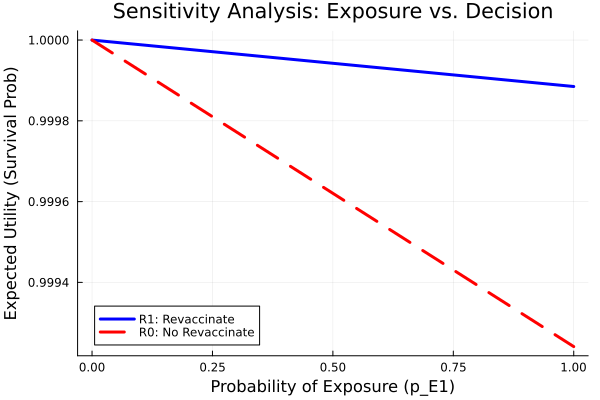

In [18]:
plot(param_values, results_R1, 
    label="R1: Revaccinate", lw=3, color=:blue, 
    xlabel="Probability of Exposure (p_E1)", 
    ylabel="Expected Utility (Survival Prob)",
    title="Sensitivity Analysis: Exposure vs. Decision",
    legend=:bottomleft)

plot!(param_values, results_R0, 
    label="R0: No Revaccinate", lw=3, color=:red, linestyle=:dash)